In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.path import Path

In [2]:
class SankeyNode:
    '''
    This class defines and draws a single node in the sankey diagram. It shouldn't need to be created
    by the end user, but one may want to edit some properties after creation.

    For example, if you wanted to edit the label format of a single node to have more decimals:
        s = Sankey(flows)
        node = s.find_node(node_name)[0]
        node.label_format = '{label} {value:,.2f}'
    '''

    def __init__(self, x, y, width, height, name, value, 
                    label='', label_format='{label}\n{value:,.0f}', label_pos='left', label_pad_x=0.01, label_opts=dict(fontsize=14), 
                    align_y='top', color='#FF33AA',
                    artist_type='rectangle', **kwargs):
        '''
        @param x : left edge, typically the flow level, as a 0-indexed integer. 1 = distance between nodes 
        @param y : bottom edge, between [0, 1]
        @param width : 1 = distance between nodes
        @param height : total extent of axis is 1
        @param name : aunique name to refer to this node
        @param value : the value of this node
        @param align_y : how to align the flows that enter/exit the node. Options: {'top', 'top overlap'}
        @param color : any matplotlib color specifier
        @param label : alternative name to display. If not label, uses `name`
        @param label_format : format string that can optionally have 'label' and 'value' fields. Set to '' to remove labels
        @param label_pos : position of the label {'left', 'right', 'top', 'bottom', 'center'}
        @param label_pad_x : padding in x from the node, as fraction of distance between nodes
        @param label_opts : dictionary with additional options for the label. See matplotlib.axis.text() for options
        '''
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.name = name
        self.value = value
        self.label = label or name
        self.label_format = label_format
        self.label_pos = label_pos
        self.label_pad_x = label_pad_x
        self.label_opts = label_opts
        self.artist_type = artist_type
        self.align_y = align_y
        self.color = color
        self.flow_pad = 0 # vertical padding between flow endpoints
        self.inflows = []
        self.outflows = []
        self.artist = None
        self.text = None


    def get_flow_y(self, i, side):
        '''
        Returns the (y_low, y_hi) position of flow i on the given side {'inflows', 'outflows'}
        '''
        flows = getattr(self, side)
        value_scale = self.value / (self.height - self.flow_pad * (len(flows) - 1))
        if self.align_y == 'top overlap':
            if len(flows) > 1 and (total := sum(x.value for x in flows)) > self.value:
                overlap = (total - self.value) / (len(flows) - 1) / value_scale
                y1 = self.y + self.height - (np.sum([x.value for x in flows[:i]]) / value_scale + (self.flow_pad - overlap) * i)
                y0 = y1 - flows[i].value / value_scale
                return (y0, y1)
            # else use 'top' below
        
        if 'top' in self.align_y:
            y1 = self.y + self.height - (np.sum([x.value for x in flows[:i]]) / value_scale + self.flow_pad * i)
            y0 = y1 - flows[i].value / value_scale
            return (y0, y1)
        else:
            raise NotImplementedError("align_y: " + self.align_y)

    def draw(self, ax):
        # Node
        if self.artist_type == 'rectangle':
            self.artist = mpatches.Rectangle((self.x, self.y), self.width, self.height)
        else:
            raise NotImplementedError("artist: {}".format(self.artist_type))
        self.artist.set_color(self.color)
        self.artist.set_edgecolor(None)
        ax.add_patch(self.artist)

        # Label
        if self.label_format:
            if self.label_pos == 'left':
                x = self.x - self.label_pad_x
                y = self.y + self.height / 2
                ha = 'right'
                va = 'center'
            elif self.label_pos == 'right':
                x = self.x + self.width + self.label_pad_x
                y = self.y + self.height / 2
                ha = 'left'
                va = 'center'
            elif self.label_pos == 'top':
                x = self.x + self.width / 2
                y = self.y + self.height
                ha = 'center'
                va = 'bottom'
            elif self.label_pos == 'bottom':
                x = self.x + self.width / 2
                y = self.y
                ha = 'center'
                va = 'top'
            elif self.label_pos == 'center':
                x = self.x + self.width / 2
                y = self.y + self.height / 2
                ha = 'center'
                va = 'center'
            else:
                raise ValueError("label_pos: " + self.label_pos)
            self.text = ax.text(x, y, self.label_format.format(label=self.label, value=self.value), ha=ha, va=va, **self.label_opts)



class SankeyFlow:
    '''
    This class defines and draws a single flow in the sankey diagram. It shouldn't need to be created
    by the end user, but one may want to edit some properties after creation.
    '''

    path_codes = [
        Path.MOVETO, # Top left
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4, # Top right
        Path.LINETO, # Bottom right
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4, # Bottom left
        Path.CLOSEPOLY
    ]

    def __init__(self, src, des, value, curvature = 0.3, color='#AAAAAA66', **kwargs):
        '''
        @param src : the source node
        @param des : the destination node
        @param value : value of the flow
        @param curvature : how curvy the flows are, with 0 = no curve and 1 = maximal curve
        @param color : Any matplotlib color specifier
        '''
        self.value = value
        self.curvature = curvature
        self.color = color
        self.node_pad = 0 # x padding from the node (sometimes they overlap), as fraction of distance between nodes in x
        self.artist = None

        self.src = src
        self.des = des
        self.src_i = len(src.outflows)
        self.des_i = len(des.inflows)
        src.outflows.append(self)
        des.inflows.append(self)


    def draw(self, ax):

        if self.src.artist_type != 'rectangle':
            raise NotImplementedError("artist: {}".format(self.src.artist_type))
        if self.des.artist_type != 'rectangle':
            raise NotImplementedError("artist: {}".format(self.des.artist_type))

        x1 = self.src.x + self.src.width + self.node_pad
        x2 = self.des.x - self.node_pad
        (y1_1, y1_2) = self.src.get_flow_y(self.src_i, 'outflows')
        (y2_1, y2_2) = self.des.get_flow_y(self.des_i, 'inflows')

        if self.curvature == 0:
            self.artist = mpatches.Polygon([
                [x1, y1_2], # top left
                [x2, y2_2], # top right
                [x2, y2_1], # bottom right
                [x1, y1_1], # bottom left
            ])
            self.artist.set_color(self.color)
            self.artist.set_edgecolor(None)
        else:
            poly_x1 = x1 + self.curvature * (x2 - x1)
            poly_x2 = x2 - self.curvature * (x2 - x1)
            path = Path([
                    [x1, y1_2], # top left
                    [poly_x1, y1_2], # top control 1
                    [poly_x2, y2_2], # top control 2
                    [x2, y2_2], # top right
                    [x2, y2_1], # bottom right
                    [poly_x2, y2_1], # bottom control 1
                    [poly_x1, y1_1], # bottom control 2
                    [x1, y1_1], # bottom left
                    [0, 0], # end
                ], SankeyFlow.path_codes)
            self.artist = mpatches.PathPatch(path, facecolor=self.color, linewidth=0)
            self.artist.set_edgecolor(None)
        
        ax.add_patch(self.artist)


class Sankey:
    '''
    This class creates and manages a sankey diagram. The typical workflow is:
        s = Sankey()
        s.sankey(flows, nodes)
        s.draw()
        plt.show()
    '''

    def __init__(self, flows=None, nodes=None, align_y='top', 
                    cmap=plt.cm.tab10, flow_color_mode='dest', flow_color_mode_alpha=0.6, 
                    node_width=0.03, node_height_pad_min=0, node_pad_y_min=0.01, node_pad_y_max=0.05,
                    node_opts={}, flow_opts={}, **kwargs):
        '''
        @param flows : see Sankey.sankey(). Can optionally input flows here as a shortcut
        @param nodes : see Sankey.sankey(). Can optionally input nodes here as a shortcut
        @param align_y : vertical alignment of the nodes {'top', 'center', 'bottom', 'justify', 'tree', 'tree clamp'}. If array-like, padding in each level
        @param cmap : colormap for default colors
        @param flow_color_mode : {'source', 'dest', 'lesser', 'greater', None}
                    'source', 'dest' : the flows will be colored the same as the source/destination node
                    'lesser', 'greater' : the flows will be colored as the node with the lesser/greater value 
        @param flow_color_mode_alpha : transparency of the flows
        @param node_width : width of the nodes, as fraction of distance between nodes
        @param node_height_pad_min : if node.height < node_height_pad_min, adds additional y padding. Value is a fraction of axis height. If array-like, padding in each level
        @param node_pad_y_min : minimum vertical padding between nodes, as fraction of distance between nodes. If array-like, padding in each level
        @param node_pad_y_max : maximum vertical padding between nodes, as fraction of distance between nodes. If array-like, padding in each level
        @param node_opts : a dictionary of options to SankeyNode() that is applied to all nodes
        @param flow_opts : a dictionary of options to SankeyFlow() that is applied to all flows
        '''
        self.align_y = align_y
        self.cmap = cmap
        self.flow_color_mode = flow_color_mode
        self.flow_color_mode_alpha = flow_color_mode_alpha
        self.node_width = node_width
        self.node_height_pad_min = node_height_pad_min
        self.node_pad_y_min = node_pad_y_min
        self.node_pad_y_max = node_pad_y_max
        self.node_opts = node_opts
        self.flow_opts = flow_opts

        self.nodes = [] # Nested list of SankeyNode, indexed by (node_level, i_node)
        self.flows = [] # List of SankeyFlows

        if flows or nodes:
            self.sankey(flows, nodes)

    def find_node(self, name):
        '''
        Finds the node with the given name and returns it and its level in the current diagram (node, level)
        '''
        for level,node_level in enumerate(self.nodes):
            for node in node_level:
                if node.name == name:
                    return (node, level)
        return (None, None)

    @staticmethod
    def infer_nodes(flows):
        '''
        Given a list of flows, automatically infers the nodes and returns them in a nested list which
        can be directly input into sankey(). The flows must not have loops or backwards flows.

        @param flows : See Sankey.sankey()
        '''
        from collections import defaultdict
        nodes = defaultdict(lambda: [0, 0, 0, set(), set()]) # min_level, in_value, out_value, parents, children
        max_level = 0

        for flow in flows:
            src = nodes[flow[0]]
            des = nodes[flow[1]]
            if des[0] <= src[0]:
                des[0] = src[0] + 1
                max_level = max(max_level, des[0])
            src[2] += flow[2]
            des[1] += flow[2]
            src[4].add(flow[1])
            des[3].add(flow[0])

        arr = [[] for _ in range(max_level+1)]
        for k,v in nodes.items():
            # maximize the level
            level = v[0]
            for child in v[4]:
                level = max(level, nodes[child][0] - 1)
            arr[level].append([k, max(v[1], v[2])])

        return arr

    def _get_opt(self, opt, level):
        '''
        Some options can be array-like, in which case index by node level
        '''
        val = getattr(self, opt)
        if isinstance(val, tuple) or isinstance(val, list):
            return val[level]
        else:
            return val

    def _value_scale_level(self, level, nodes_level):
        '''
        Finds the value scale such that this level ranges exactly from y=[0,1] including padding
        '''
        min_pad = self._get_opt('node_pad_y_min', level) * (len(nodes_level) - 1)
        heights = np.array([node[1] for node in nodes_level])
        scale = np.sum(heights) / (1 - min_pad)
        node_height_pad_min = self._get_opt('node_height_pad_min', level)
        if node_height_pad_min == 0:
            return scale
        else:
            if node_height_pad_min * len(nodes_level) + min_pad > 1:
                raise ValueError('sankey: node_height_pad_min {} is too large for level with size {}'.format(node_height_pad_min, len(nodes_level)))
            
            nsmall = 0
            while (smalls := heights / scale <= node_height_pad_min).any(): # any smalls left over = we need to increase the scale
                nsmall += np.count_nonzero(smalls)
                heights = heights[~smalls]
                scale = np.sum(heights) / (1 - min_pad - nsmall * node_height_pad_min)

            return scale

    def _level_node_max_padding(self, level, nodes_level, value_scale):
        '''
        @returns the max padding that can be used in this level
        '''
        if len(nodes_level) < 2:
            return 0
        heights = np.array([node[1] for node in nodes_level]) / value_scale
        level_value = np.sum(np.maximum(heights, self._get_opt('node_height_pad_min', level)))
        return (1 - level_value) / (len(nodes_level) - 1)

    def _get_node_ys(self, level, nodes_level, value_scale):
        '''
        Returns the y-positions of the nodes in a single level as (y_low, height)
        '''
        # Options
        align_y = self._get_opt('align_y', level)
        node_pad_y_min = self._get_opt('node_pad_y_min', level)
        node_pad_y_max = self._get_opt('node_pad_y_max', level)
        node_height_pad_min = self._get_opt('node_height_pad_min', level)

        # Get padding
        max_padding = self._level_node_max_padding(level, nodes_level, value_scale)
        if align_y == 'justify':
            node_pad_y = max_padding
        else:
            node_pad_y = min(max_padding, max(node_pad_y_max, node_pad_y_min))

        # Special case for n=1 with align = center or justify. align = top or bottom can use the general code below
        if len(nodes_level) == 1 and align_y in ['center', 'justify']:
            height = nodes_level[0][1] / value_scale
            pad = (1 - height) / 2
            return [(pad, height)]

        # General case
        ys = []
        if align_y == 'bottom':
            y = 0
            for node in reversed(nodes_level):
                height = node[1] / value_scale
                if height < node_height_pad_min:
                    pos = y + (node_height_pad_min - height) / 2
                    ys.insert(0, (pos, height))
                    y += node_height_pad_min + node_pad_y
                else:
                    ys.insert(0, (y, height))
                    y += actual_height + node_pad_y
        else:
            y = 1
            if align_y == 'center':
                y -= (max_padding - node_pad_y) * (len(nodes_level) - 1) / 2
            for node in nodes_level:
                height = node[1] / value_scale
                y -= height
                if height < node_height_pad_min:
                    y -= (node_height_pad_min - height) / 2
                    ys.append((y, height))
                    y -= (node_height_pad_min - height) / 2
                else:
                    ys.append((y, height))
                y -= node_pad_y
        return ys

    def sankey(self, flows, nodes=None):
        '''
        @param flows : A list of flows as (source_name, dest_name, value) or (source_name, dest_name, value, opts),
                       where opts is a dictionary containing arguments to SankeyFlow(). opts may also contain key flow_color_mode with 
                       the same meaning as in Sankey(), but applied only to this flow. 
        @param nodes : A list of node levels, from sources to destinations. In each level, a list of nodes as (name, value) or (name, value, opts),
                       where opts is a dictionary containing arguments to SankeyNode().
        '''

        if not nodes:
            nodes = self.infer_nodes(flows)

        # Get scaling. The widest level should extend exactly from y = 0 to 1 including padding
        widest_level = 0
        value_scale = 0
        for level,nodes_level in enumerate(nodes):
            scale = self._value_scale_level(level, nodes_level)
            if scale > value_scale:
                value_scale = scale
                widest_level = level

        # Nodes
        self.nodes = []
        i_color = 0 # for automatic coloring
        for level,nodes_level in enumerate(nodes):
            arr = [] # nodes in this level
            ys = self._get_node_ys(level, nodes_level, value_scale)
            for node,(y,height) in zip(nodes_level, ys):
                # Error check
                if node[1] < 0:
                    print('Warning: Node has value < 0: {}'.format(node))

                # Node configuration
                args = dict(color=self.cmap(i_color % self.cmap.N))
                args.update(self.node_opts) # global options
                if len(node) > 2:
                    args.update(node[2]) # individual options

                # Create node
                arr.append(SankeyNode(level, y, self.node_width, height, node[0], node[1], **args))
                i_color += 1
            self.nodes.append(arr)

        # Flows
        self.flows = []
        for flow in flows:
            (src, src_level) = self.find_node(flow[0])
            (des, des_level) = self.find_node(flow[1])

            # Error check
            if not src:
                raise KeyError("Bad flow - couldn't find souce node: {}".format(flow))
            if not des:
                raise KeyError("Bad flow - couldn't find destination node: {}".format(flow))
            if flow[2] > src.value or flow[2] > des.value or flow[2] < 0:
                print("Warning: Bad flow - bad weight: {}".format(flow))
            if des_level <= src_level:
                raise ValueError("Bad flow - flow is backwards: {}".format(flow))

            # Auto color
            custom_opts = flow[3] if len(flow) > 3 else {}
            flow_color_mode = custom_opts.get('flow_color_mode', self.flow_color_mode)
            if 'dest' in flow_color_mode:
                color = des.color
            elif 'source' in flow_color_mode:
                color = src.color
            elif 'lesser' in flow_color_mode:
                color = src.color if src.value < des.value else des.color
            elif 'greater' in flow_color_mode:
                color = src.color if src.value > des.value else des.color
            else:
                color = '#AAAAAA'
            color = mcolors.to_rgba(color)
            color = (*color[:3], color[3] * self.flow_color_mode_alpha)
            
            # Create flow
            args = dict(color=color)
            args.update(self.flow_opts)
            args.update(custom_opts)
            self.flows.append(SankeyFlow(src, des, flow[2], **args))

        # Post-creation layout
        if isinstance(self.align_y, list) or isinstance(self.align_y, tuple) or 'tree' in self.align_y:
            self._layout_tree(widest_level)
    

    def _layout_tree_level(self, level, right):
        '''
        @param right : This level is right of the max level, and will base the ideal positions off of the nodes' parents. Otherwise, uses the children.
        '''
        # Options
        align_y = self._get_opt('align_y', level)
        if 'tree' not in align_y: return
        node_pad_y_min = self._get_opt('node_pad_y_min', level)
        node_height_pad_min = self._get_opt('node_height_pad_min', level)
        nodes_level = self.nodes[level]

        # Get the ideal y position such that the flows are horizontal. For nodes with a single parent,
        # this is simply the y of the flow. For nodes with multiple parents, use a weighted average.
        y_ideal = np.zeros(len(nodes_level))
        has_stress = np.ones(len(nodes_level), dtype=bool)
        for i,node in enumerate(nodes_level):
            node.y = 0 # needed when we call get_flow_y below
            total_ys = 0
            total_weights = 0
            for flow in node.inflows if right else node.outflows:
                if right:
                    y_anchor = flow.src.get_flow_y(flow.src_i, "outflows")[0]
                    y_flow_node = node.get_flow_y(flow.des_i, "inflows")[0] # since we set y to 0 above, this is the position of the flow in the node
                else:
                    y_anchor = flow.des.get_flow_y(flow.des_i, "inflows")[0]
                    y_flow_node = node.get_flow_y(flow.src_i, "outflows")[0] # since we set y to 0 above, this is the position of the flow in the node
                y_ideal_node = np.clip(y_anchor - y_flow_node, 0, 1)
                total_ys += y_ideal_node * flow.value
                total_weights += flow.value
            if total_weights > 0:
                y_ideal[i] = total_ys / total_weights
            else:
                has_stress[i] = False

        # Get the maximum height each node can have
        y_max = np.zeros(len(nodes_level))
        y = 1
        for i,node in enumerate(nodes_level):
            if node.height < node_height_pad_min:
                y_max[i] = y - (node_height_pad_min + node.height) / 2
                y -= node_height_pad_min + node_pad_y_min
            else:
                y_max[i] = y - node.height
                y -= node.height + node_pad_y_min
        y_flex = y_max[-1] # amount of extra y space available

        # Start the nodes from their maximum (top) position, then calculate the amount of "stress" each node
        # has to reach its ideal position. Large stress = wants to move down, negative stress = wants to move up.
        # If a single node wants to push down but the ones below it want to move up, we want to average
        # the stresses such that no node is too selfish. So use a weighted average of all nodes below it.
        y_stress = (y_max - y_ideal) * has_stress
        average_stress = (np.cumsum(y_stress[::-1]) / np.maximum(1, np.cumsum(has_stress[::-1])))[::-1]
        y_desired_shift = np.minimum(y_stress, average_stress)
        if 'clamp' in align_y: # we can clip here to ensure height of plot = 1 = widest layer, but not clipping looks fine too
            y_desired_shift = np.clip(y_desired_shift, 0, y_flex) 
        y_shift = np.maximum.accumulate(y_desired_shift) # if one node pushes down, the subsequent nodes must follow by at least as much
        y_new = y_max - y_shift

        # Set the new positions
        for node,pos in zip(nodes_level, y_new):
            node.y = pos

    def _layout_tree(self, max_level):
        '''
        Adjusts the positions of self.nodes to group sibling nodes next to each other and their parent. Works best when the nodes form
        a tree structure. This should be called after the flows are created but before draw(). 

        The algorithm starts from max_level and works its way out in both directions. Note that the ordering of the nodes
        (in top-to-bottom order) always takes precedence.  

        NB: Assumes max_level is set by default option in _get_node_ys()
        '''
        for level in range(max_level + 1, len(self.nodes)):
            self._layout_tree_level(level, True)
        for level in range(max_level - 1, -1, -1):
            self._layout_tree_level(level, False)

    def draw(self, ax=None):
        # Get axes
        if ax is None:
            ax = plt.gca()

        # Draw nodes
        for node_level in self.nodes:
            for node in node_level:
                node.draw(ax)

        # Draw flow
        for flow in self.flows:
            flow.draw(ax)

        #ax.axis(xmin=0, xmax=len(self.nodes)-1 + self.node_width, ymin=0, ymax=1)
        ax.axis('tight')
        ax.axis('off')

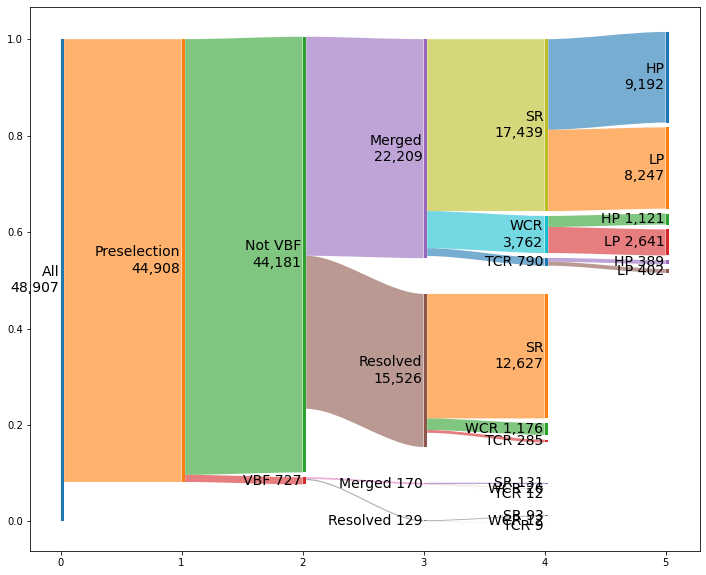

In [10]:
plt.figure(figsize=(12, 10))
align_y = ['tree'] * 6
align_y[3] = 'justify'
s = Sankey(flows=flows, nodes=nodes, flow_color_mode='lesser', align_y=align_y)
s.draw()

plt.gca().axis('on')
plt.gcf().set_facecolor('white')
plt.show()

In [5]:
# test
nodes = [
    [('A', 10)],
    [('B1', 4), ('B2', 5)],
    [('C', 3), ('D', 4)],
]
flows = [
    ('A', 'B1', 4),
    ('A', 'B2', 5),
    ('B1', 'C', 1),
    ('B2', 'C', 2),
    ('B2', 'D', 4),
] 

In [ ]:
# Microsoft

flows = [
    ('Product', 'Total revenue', 20779),
    ('Sevice\nand other', 'Total revenue', 30949),
    ('Total revenue', 'Gross margin', 34768),
    ('Total revenue', 'Cost of revenue', 16960),
    ('Other income, net', 'Income before\nincome taxes', 268),
    ('Gross margin', 'Operating income', 22247),
    ('Operating income', 'Income before\nincome taxes', 22247, {'flow_color_mode': 'dest'}),
    ('Gross margin', 'Research and\ndevelopment', 5758), 
    ('Gross margin', 'Sales and marketing', 5379), 
    ('Gross margin', 'General and\nadministrative', 1384),
    ('Income before\nincome taxes', 'Net income', 18765), 
    ('Income before\nincome taxes', 'Provision for\nincome taxes', 3750),
]
nodes = None

In [7]:
# Cutflow

nodes = None
flows = [['All', 'Preselection', 44907.936681102205], ['Preselection', 'Not VBF', 44181.36375494944], ['Not VBF', 'GGF Merged', 22209.311612648344], ['GGF Merged', 'GGF Merged SR', 17439.401511783104], ['GGF Merged SR', 'GGF Merged SR HP', 9192.051334154343], ['GGF Merged SR', 'GGF Merged SR LP', 8247.350177628761], ['GGF Merged', 'GGF Merged WCR', 3761.857136480797], ['GGF Merged WCR', 'GGF Merged WCR HP', 1121.073906502942], ['GGF Merged WCR', 'GGF Merged WCR LP', 2640.7832299778474], ['GGF Merged', 'GGF Merged TCR', 790.3765654304393], ['GGF Merged TCR', 'GGF Merged TCR HP', 388.68612827305776], ['GGF Merged TCR', 'GGF Merged TCR LP', 401.6904371573816], ['Not VBF', 'GGF Resolved', 15525.872134691675], ['GGF Resolved', 'GGF Resolved SR', 12626.53146394376], ['GGF Resolved', 'GGF Resolved WCR', 1176.3639430235519], ['GGF Resolved', 'GGF Resolved TCR', 284.8703984027244], ['Preselection', 'VBF', 726.5729261526669], ['VBF', 'VBF Merged', 170.23010030958667], ['VBF Merged', 'VBF Merged SR', 131.47415874418914], ['VBF Merged', 'VBF Merged WCR', 25.664783535182735], ['VBF Merged', 'VBF Merged TCR', 12.182428084112578], ['VBF', 'VBF Resolved', 128.85512505935765], ['VBF Resolved', 'VBF Resolved SR', 93.07252581602002], ['VBF Resolved', 'VBF Resolved WCR', 11.577275761453741], ['VBF Resolved', 'VBF Resolved TCR', 9.320528181085981]] 
nodes = [[['All', 48906.790137865966, {'label': 'All'}]], [['Preselection', 44907.936681102205, {'label': 'Preselection'}]], [['Not VBF', 44181.36375494944, {'label': 'Not VBF'}], ['VBF', 726.5729261526669, {'label': 'VBF', 'label_format': '{label} {value:,.0f}'}]], [['GGF Merged', 22209.311612648344, {'label': 'Merged'}], ['GGF Resolved', 15525.872134691675, {'label': 'Resolved'}], ['VBF Merged', 170.23010030958667, {'label': 'Merged', 'label_format': '{label} {value:,.0f}'}], ['VBF Resolved', 128.85512505935765, {'label': 'Resolved', 'label_format': '{label} {value:,.0f}'}]], [['GGF Merged SR', 17439.401511783104, {'label': 'SR'}], ['GGF Merged WCR', 3761.857136480797, {'label': 'WCR'}], ['GGF Merged TCR', 790.3765654304393, {'label': 'TCR', 'label_format': '{label} {value:,.0f}'}], ['GGF Resolved SR', 12626.53146394376, {'label': 'SR'}], ['GGF Resolved WCR', 1176.3639430235519, {'label': 'WCR', 'label_format': '{label} {value:,.0f}'}], ['GGF Resolved TCR', 284.8703984027244, {'label': 'TCR', 'label_format': '{label} {value:,.0f}'}], ['VBF Merged SR', 131.47415874418914, {'label': 'SR', 'label_format': '{label} {value:,.0f}'}], ['VBF Merged WCR', 25.664783535182735, {'label': 'WCR', 'label_format': '{label} {value:,.0f}'}], ['VBF Merged TCR', 12.182428084112578, {'label': 'TCR', 'label_format': '{label} {value:,.0f}'}], ['VBF Resolved SR', 93.07252581602002, {'label': 'SR', 'label_format': '{label} {value:,.0f}'}], ['VBF Resolved WCR', 11.577275761453741, {'label': 'WCR', 'label_format': '{label} {value:,.0f}'}], ['VBF Resolved TCR', 9.320528181085981, {'label': 'TCR', 'label_format': '{label} {value:,.0f}'}]], [['GGF Merged SR HP', 9192.051334154343, {'label': 'HP'}], ['GGF Merged SR LP', 8247.350177628761, {'label': 'LP'}], ['GGF Merged WCR HP', 1121.073906502942, {'label': 'HP', 'label_format': '{label} {value:,.0f}'}], ['GGF Merged WCR LP', 2640.7832299778474, {'label': 'LP', 'label_format': '{label} {value:,.0f}'}], ['GGF Merged TCR HP', 388.68612827305776, {'label': 'HP', 'label_format': '{label} {value:,.0f}'}], ['GGF Merged TCR LP', 401.6904371573816, {'label': 'LP', 'label_format': '{label} {value:,.0f}'}]]]   